# Classifiers - low vs high complexity - no TFv1
Exploring different classifiers with different autoencoders. No contractive autoencoder because it needs TFv1 compatibility.

#### Table of contents:  

autoencoders:  
[Undercomplete Autoencoder](#Undercomplete-Autoencoder)  
[Sparse Autoencoder](#Sparse-Autoencoder)  
[Deep Autoencoder](#Deep-Autoencoder)  

classifiers:  
[Simple dense classifier](#Simple-dense-classifier)  
[LSTM-based classifier](#LSTM-based-classifier)  
[kNN](#kNN)  
[SVC](#SVC)  
[Random Forest](#Random-Forest)  
[XGBoost](#XGBoost)  

In [1]:
import datareader # made by the previous author for reading the collected data
import dataextractor # same as above
import pandas
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, Nadam
import tensorflow.keras.backend as K
tf.keras.backend.set_floatx('float32') # call this, to set keras to use float32 to avoid a warning message
metrics = ['accuracy']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import json
from datetime import datetime
import warnings
import matplotlib.pyplot as plt

In [2]:
import random

random.seed(1)
np.random.seed(4)
tf.random.set_seed(2)

In [3]:
# Start the notebook in the terminal with "PYTHONHASHSEED=0 jupyter notebook" 
# or in anaconda "set PYTHONHASHSEED=0" then start jupyter notebook
import os
if os.environ.get("PYTHONHASHSEED") != "0":
    raise Exception("You must set PYTHONHASHSEED=0 before starting the Jupyter server to get reproducible results.")

This is modfied original author's code for reading data:

In [4]:
def model_train(model, x_train, y_train, batch_size, epochs, x_valid, y_valid, x_test, y_test):
    """Train model with the given training, validation, and test set, with appropriate batch size and # epochs."""
    epoch_data = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid, y_valid), verbose=0)
    score = model.evaluate(x_test, y_test, batch_size=batch_size, verbose=0)
    acc = score[1]
    score = score[0]
    return score, acc, epoch_data


In [5]:
def get_task_complexities_timeframes_br_hb(path, ident, seconds):
    """Returns raw data along with task complexity class.
    TODO: join functions. Add parameter to choose different task types and complexities"""

    dataread = datareader.DataReader(path, ident)  # initialize path to data
    data = dataread.read_grc_data()  # read from files
    samp_rate = int(round(len(data[1]) / max(data[0])))
    cog_res = dataread.read_cognitive_load_study(str(ident) + '-primary-extract.txt')

    tasks_data = np.empty((0, seconds*samp_rate))
    tasks_y = np.empty((0, 1))
    breathing = np.empty((0,12))
    heartbeat = np.empty((0,10))

    busy_n = dataread.get_data_task_timestamps(return_indexes=True)
    
    for i in cog_res['task_number']:
        task_num_table = i - 225  # 0 - 17
        tmp_tasks_data = np.empty((0, seconds*samp_rate))
        tmp_tasks_y = np.empty((0, 1))
        tmp_breathing = np.empty((0,12))
        tmp_heartbeat = np.empty((0,10))
        
        ### task complexity classification
        if cog_res['task_complexity'][task_num_table] == 'medium':
            continue
        # if cog_res['task_label'][task_num_table] == 'FA' or cog_res['task_label'][task_num_table] == 'HP':
        #     continue
#         if cog_res['task_label'][task_num_table] != 'NC':
#             continue
            
        map_compl = {
            'low': 0,
            'medium': 2,
            'high': 1
        }
        for j in range(10):
            new_end = int(busy_n[task_num_table][1] - j * samp_rate)
            new_start = int(new_end - samp_rate*30)
            dataextract = dataextractor.DataExtractor(data[0][new_start:new_end],
                                                      data[1][new_start:new_end], samp_rate)
            # get extracted features for breathing
            tmpBR = dataextract.extract_from_breathing_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            #get extracted features for heartbeat
            tmpHB = dataextract.extract_from_heartbeat_time(data[0][new_start:new_end],
                                                                 data[1][new_start:new_end])
            
            try:
                
                tmp_tasks_data = np.vstack((tmp_tasks_data, dataextract.y[-samp_rate * seconds:]))
                tmp_tasks_y = np.vstack((tmp_tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))

                tmp_breathing = np.vstack((tmp_breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                tmp_heartbeat = np.vstack((tmp_heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
                
            except ValueError:
#                 print(ident)
                continue

            tasks_data = np.vstack((tasks_data, dataextract.y))
            tasks_y = np.vstack((tasks_y, map_compl.get(cog_res['task_complexity'][task_num_table])))
            breathing = np.vstack((breathing, tmpBR.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            heartbeat = np.vstack((heartbeat, tmpHB.to_numpy(dtype='float64', na_value=0)[0][:-1]))
            
    return tasks_data, tasks_y, breathing, heartbeat

In [6]:
def get_data_from_idents_br_hb(path, idents, seconds):
    """Go through all user data and take out windows of only <seconds> long time frames,
    along with the given class (from 'divide_each_task' function).
    """
    samp_rate = 43  # hard-coded sample rate
    data, ys = np.empty((0, samp_rate*seconds)), np.empty((0, 1))
    brs = np.empty((0,12))
    hbs = np.empty((0,10))
    combined = np.empty((0,22))
    
    # was gettign some weird warnings; stack overflow said to ignore them
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        for i in idents:
            #x, y, br, hb = get_busy_vs_relax_timeframes_br_hb(path, i, seconds) # either 'get_busy_vs_relax_timeframes',
            # get_engagement_increase_vs_decrease_timeframes, get_task_complexities_timeframes or get_TLX_timeframes
            x, y, br, hb = get_task_complexities_timeframes_br_hb(path, i, seconds)
            
            data = np.vstack((data, x))
            ys = np.vstack((ys, y))
            brs = np.vstack((brs, br))
            hbs = np.vstack((hbs, hb))
        combined = np.hstack((brs,hbs))
    
    return data, ys, brs, hbs, combined

In [7]:
# Accs is a dictionary which holds 1d arrays of accuracies in each key
# except the key 'test id' which holds strings of the id which yielded the coresponding accuracies
def print_accs_stats(accs):
    
    printDict = {}
    # loop over each key
    for key in accs:
    
        if (key == 'test id'):
            # skip calculating ids
            continue
        printDict[key] = {}
        tmpDict = printDict[key]
        # calculate and print some statistics
        tmpDict['min'] = np.min(accs[key])
        tmpDict['max'] = np.max(accs[key])
        tmpDict['mean'] = np.mean(accs[key])
        tmpDict['median'] = np.median(accs[key])
    
    print(pandas.DataFrame.from_dict(printDict).to_string())

In [8]:
def clear_session_and_set_seeds():
    # clear session and set seeds again
    K.clear_session()
    random.seed(1)
    np.random.seed(4)
    tf.random.set_seed(2)

## Prepare data

Initialize variables:

In [9]:
# initialize a dictionary to store accuracies for comparison
accuracies = {}

# used for reading the data into an array
seconds = 30  # time window length
samp_rate = 43  # hard-coded sample rate
phase_shape = np.empty((0, samp_rate*seconds))
y_shape = np.empty((0, 1))
breathing_shape = np.empty((0,12))
heartbeat_shape = np.empty((0,10))
combined_shape = np.empty((0,22))
idents = ['2gu87', 'iz2ps', '1mpau', '7dwjy', '7swyk', '94mnx', 'bd47a', 'c24ur', 'ctsax', 'dkhty', 'e4gay',
              'ef5rq', 'f1gjp', 'hpbxa', 'pmyfl', 'r89k1', 'tn4vl', 'td5pr', 'gyqu9', 'fzchw', 'l53hg', '3n2f9',
              '62i9y']
path = '../../../StudyData/'


# change to len(idents) at the end to use all the data
n = len(idents)

In [10]:
# load all phase data to use for training autoencoders
phase_all_train = get_data_from_idents_br_hb(path, idents[:-2], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_train = MinMaxScaler().fit_transform(phase_all_train.T).T

# load all validation phase data to use for training autoencoders
phase_all_valid = get_data_from_idents_br_hb(path, idents[-2:], seconds)[0]
# Scale each row with MinMax to range [0,1]
phase_all_valid = MinMaxScaler().fit_transform(phase_all_valid.T).T

In [11]:
# Holds all the data so it doesnt have to be read from file each time
data_dict = {}

Fill the data dictionary:

In [12]:
for ident in idents:
    
    # initialize ident in 
    data_dict[ident] = {}
    tmpDataDict = data_dict[ident]
    
    # read data
    phase, y, breathing, heartbeat, combined = get_data_from_idents_br_hb(path, [ident], seconds)
    
    # load data into dictionary
    tmpDataDict['phase'] = phase
    tmpDataDict['y'] = y
    tmpDataDict['breathing'] = breathing
    tmpDataDict['heartbeat'] = heartbeat
    tmpDataDict['combined'] = combined

## Autoencoders  
Train autoencoders to save their encoded representations in the data dictionary:

In [13]:
# AE Training params
batch_size = 128
epochs = 1000
encoding_dim = 30
ae_encoded_shape = np.empty((0,encoding_dim))

In [14]:
def compare_plot_n(data1, data2, plot_n=12):
    
    #plot data1 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data1[i])

    #plot data2 values
    plt.figure()
    plt.figure(figsize=(20, 4))
    for i in range(plot_n):
        plt.subplot(plot_n/5, 6, i+1)
        plt.plot(data2[i])

#### Undercomplete Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [15]:
def undercomplete_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42)(input_data)
    # "encoded" is the encoded representation of the input
    encoded = Dense(encoding_dim, activation='relu', name="encoded")(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    autoencoder = Model(input_data, decoded)
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [16]:
clear_session_and_set_seeds()
uc_ae, uc_enc = undercomplete_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
uc_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

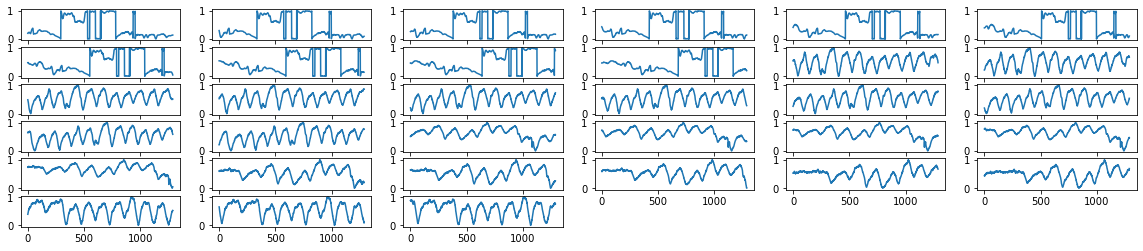

<Figure size 432x288 with 0 Axes>

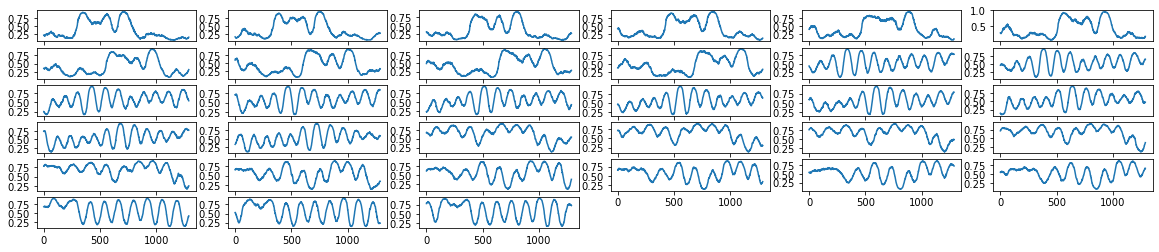

In [17]:
data2 = uc_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

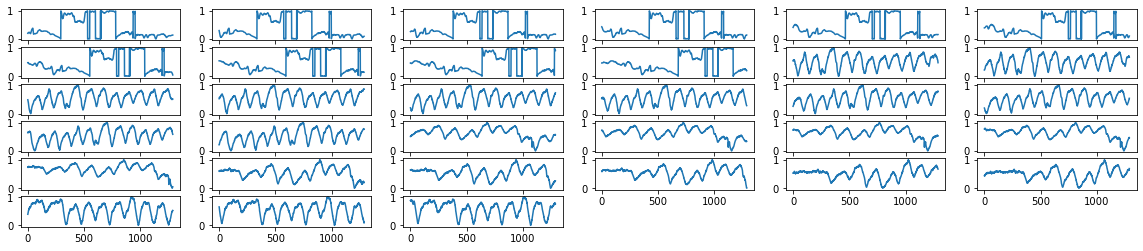

<Figure size 432x288 with 0 Axes>

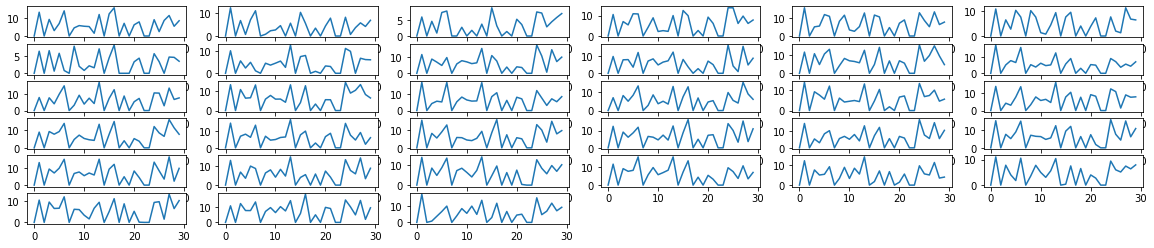

In [18]:
data2 = uc_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [19]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    uc_data = uc_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['undercomplete_encoded'] = uc_data

#### Sparse Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [20]:
def sparse_ae(x, encoding_dim=64, encoded_as_model=False):
    # Simplest possible autoencoder from https://blog.keras.io/building-autoencoders-in-keras.html

    # this is our input placeholder
    input_data = Input(shape=x[0].shape, name="input")
    dropout = Dropout(0.125, name="dropout", seed=42) (input_data)
    # "encoded" is the encoded representation of the input
    # add a sparsity constraint
    encoded = Dense(encoding_dim, activation='relu', name="encoded",
                    activity_regularizer=regularizers.l1(10e-5))(dropout)
    
    # "decoded" is the lossy reconstruction of the input
    decoded = Dense(x[0].shape[0], activation='sigmoid', name="decoded")(encoded)

    # this model maps an input to its reconstruction
    autoencoder = Model(input_data, decoded, name="sparse_ae")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)
    
    return autoencoder, encoded

Train autoencoder on data:

In [21]:
clear_session_and_set_seeds()
sp_ae, sp_enc = sparse_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
sp_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

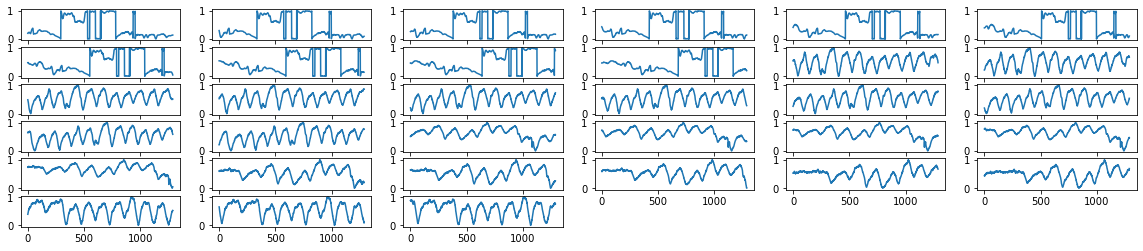

<Figure size 432x288 with 0 Axes>

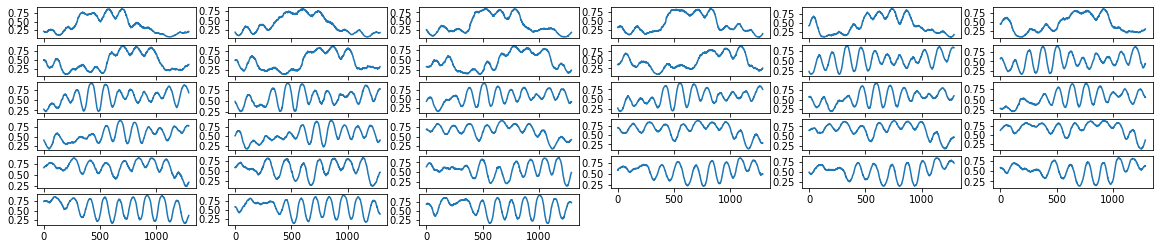

In [22]:
data2 = sp_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

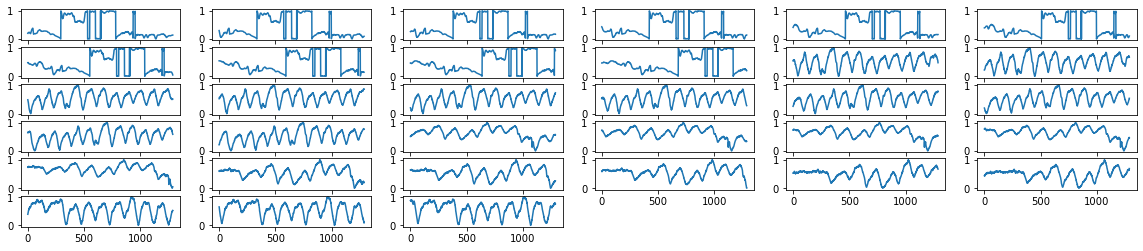

<Figure size 432x288 with 0 Axes>

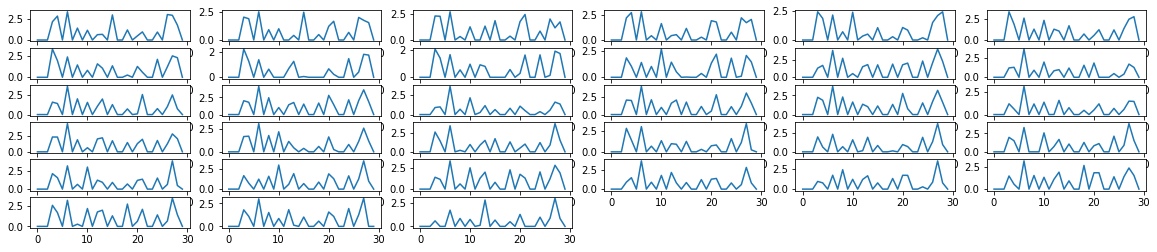

In [23]:
data2 = sp_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [24]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    sp_data = sp_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['sparse_encoded'] = sp_data

#### Deep Autoencoder  
from https://blog.keras.io/building-autoencoders-in-keras.html

In [25]:
def deep_ae(x, enc_layers=[512,128], encoding_dim=64, dec_layers=[128,512], encoded_as_model=False):
    # From https://www.tensorflow.org/guide/keras/functional#use_the_same_graph_of_layers_to_define_multiple_models
    input_data = keras.Input(shape=x[0].shape, name="normalized_signal")
    model = Dropout(0.125, name="dropout", autocast=False, seed=42)(input_data)
    for i in enumerate(enc_layers):
        model = Dense(i[1], activation="relu", name="dense_enc_" + str(i[0]+1))(model)
    encoded_output = Dense(encoding_dim, activation="relu", name="encoded_signal")(model)

    encoded = encoded_output

    model = layers.Dense(dec_layers[0], activation="sigmoid", name="dense_dec_1")(encoded_output)
    for i in enumerate(dec_layers[1:]):
        model = Dense(i[1], activation="sigmoid", name="dense_dec_" + str(i[0]+2))(model)
    decoded_output = Dense(x[0].shape[0], activation="sigmoid", name="reconstructed_signal")(model)
    
    autoencoder = Model(input_data, decoded_output, name="autoencoder")
    
    # compile the model
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
    
    # if return encoder in the encoded variable
    if encoded_as_model:
        encoded = Model(input_data, encoded)

    return autoencoder, encoded

Train autoencoder on data:

In [26]:
clear_session_and_set_seeds()
de_ae, de_enc = deep_ae(phase_all_train, encoding_dim=encoding_dim, encoded_as_model=True)
de_ae.fit(phase_all_train, phase_all_train,
          validation_data=(phase_all_valid, phase_all_valid),
          batch_size=batch_size,
          shuffle=True,
          epochs=epochs,
          verbose=0)

Plot some reconstructions to compare:

<Figure size 432x288 with 0 Axes>

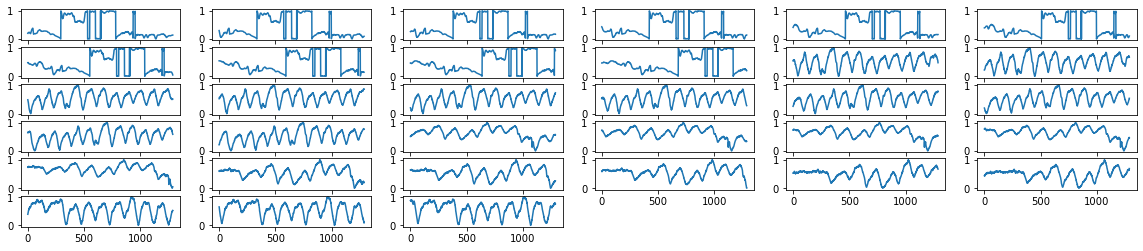

<Figure size 432x288 with 0 Axes>

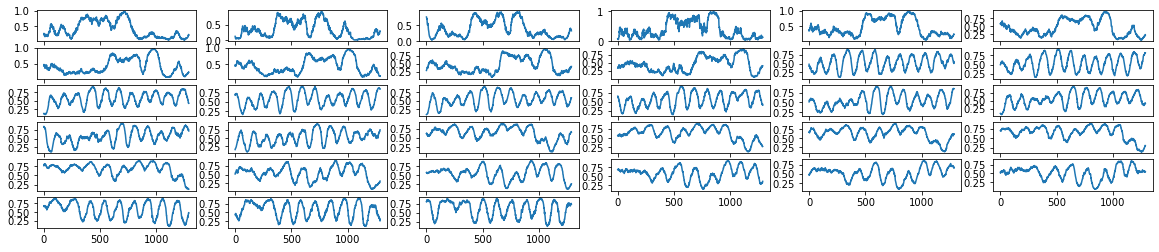

In [27]:
data2 = de_ae.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Plot signal and its encoded representation:

<Figure size 432x288 with 0 Axes>

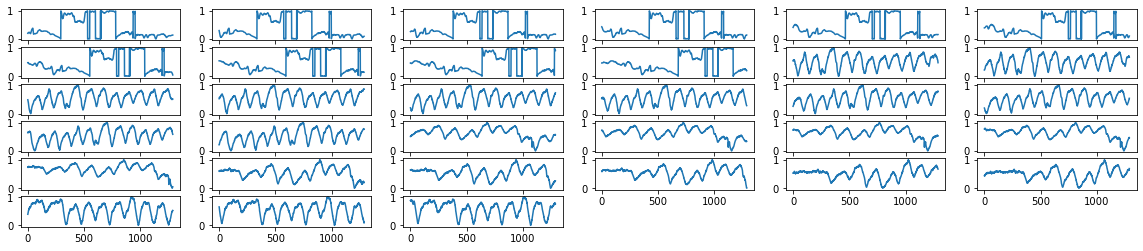

<Figure size 432x288 with 0 Axes>

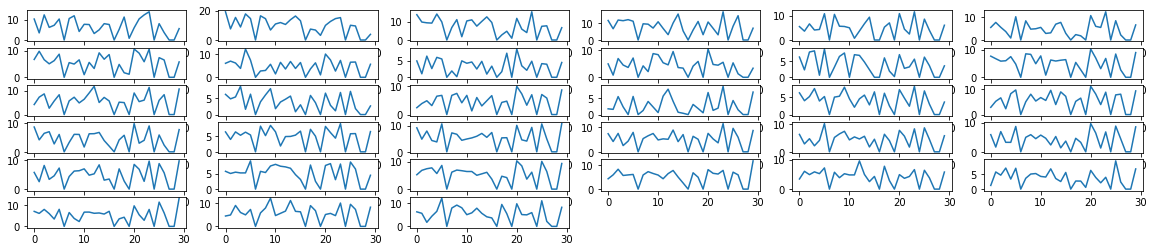

In [28]:
data2 = de_enc.predict(phase_all_valid)
compare_plot_n(phase_all_valid, data2, 33)

Store the encoded representations in the data dictionary:

In [29]:
for ident in data_dict:
    
    tmpDataDict = data_dict[ident]
    
    # read data
    phase = tmpDataDict['phase']
    
    de_data = de_enc.predict(phase)
    
    # load data into dictionary
    tmpDataDict['deep_encoded'] = de_data

Helper function to get data from the dictionary:

In [30]:
def get_ident_data_from_dict(idents, data_dict):
    
    # Initialize data variables
    y = y_shape.copy()
    phase = phase_shape.copy()
    breathing = breathing_shape.copy()
    heartbeat = heartbeat_shape.copy()
    combined = combined_shape.copy()
    undercomplete_encoded = ae_encoded_shape.copy()
    sparse_encoded = ae_encoded_shape.copy()
    deep_encoded = ae_encoded_shape.copy()
    
    # Stack data form each ident into the variables
    for tmp_id in idents:
        y = np.vstack((y, data_dict[tmp_id]['y']))
        phase = np.vstack((phase, data_dict[tmp_id]['phase']))
        breathing = np.vstack((breathing, data_dict[tmp_id]['breathing']))
        heartbeat = np.vstack((heartbeat, data_dict[tmp_id]['heartbeat']))
        combined = np.vstack((combined, data_dict[tmp_id]['combined']))
        undercomplete_encoded = np.vstack((undercomplete_encoded, data_dict[tmp_id]['undercomplete_encoded']))
        sparse_encoded = np.vstack((sparse_encoded, data_dict[tmp_id]['sparse_encoded']))
        deep_encoded = np.vstack((deep_encoded, data_dict[tmp_id]['deep_encoded']))
    
    return y, phase, breathing, heartbeat, combined, undercomplete_encoded, sparse_encoded, deep_encoded

## Classifiers

#### Helper loop function definition  
A function that loops over all the data and calls the classifiers with it then stores the returned accuracies.

In [31]:
def helper_loop(classifier_function_train, idents, n=5, num_loops_to_average_over=1, should_scale_data=True):
    #returns a dictionary with accuracies

    # set the variables in the dictionary
    accs = {}
    accs['phase'] = []
    accs['breathing'] = []
    accs['heartbeat'] = []
    accs['combined br hb'] = []
    accs['undercomplete'] = []
    accs['sparse'] = []
    accs['deep'] = []
    accs['test id'] = []
    start_time = datetime.now()

    # leave out person out validation
    for i in range(n):
        
        # print current iteration and time elapsed from start
        print("iteration:", i+1, "of", n, "; time elapsed:", datetime.now()-start_time)

        ## ----- Data preparation:
        validation_idents = [idents[i]]
        test_idents = [idents[i-1]]
        
        train_idents = []
        for ident in idents:
            if (ident not in test_idents) and (ident not in validation_idents):
                train_idents.append(ident)

        # save test id to see which id yielded which accuracies
        accs['test id'].append(test_idents[0])

        # Load train data
        train_data = get_ident_data_from_dict(train_idents, data_dict)
        y_train = train_data[0]
        
        # Load validation data
        valid_data = get_ident_data_from_dict(validation_idents, data_dict)
        y_valid = valid_data[0]

        # Load test data
        test_data = get_ident_data_from_dict(test_idents, data_dict)
        y_test = test_data[0]
        
        data_names_by_index = ['y', 'phase', 'breathing', 'heartbeat',
                                   'combined br hb', 'undercomplete', 'sparse', 'deep']

        # Loop over all data that will be used for classification and send it to the classifier
        # index 0 is y so we skip it
        for index in range(1, len(test_data)):
            clear_session_and_set_seeds()
            train_x = train_data[index]
            valid_x = valid_data[index]
            test_x = test_data[index]
            
            # Scale data
            if should_scale_data:
                # Scale with standard scaler
                sscaler = StandardScaler()
                sscaler.fit(train_x)
                train_x = sscaler.transform(train_x)

                # Scale valid and test with train's scaler
                valid_x = sscaler.transform(valid_x)
                test_x = sscaler.transform(test_x)
            
            # Initialize variables
            tmp_acc = []
            data_name = data_names_by_index[index]
            
            for tmp_index in range(num_loops_to_average_over):
                curr_acc = classifier_function_train(train_x, y_train, valid_x, y_valid, test_x, y_test, data_name)
                tmp_acc.append(curr_acc)
            
            # Store accuracy
            curr_acc = np.mean(tmp_acc)
            accs[data_name].append(curr_acc)
        

    # Print total time required to run this
    end_time = datetime.now()
    elapsed_time = end_time - start_time
    print("Completed!", "Time elapsed:", elapsed_time)
    
    return accs

#### Simple dense classifier

Define the classifier:

In [32]:
params_dense_phase = {
    'dropout': 0.4,
    'hidden_size': 26,
    'activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'batch_size': 128,
    'learning_rate': 0.001,
    'epochs': 300
}

In [33]:
params_dense_br_hb = {
    'dropout': 0.05,
    'hidden_size': 24,
    'activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.05,
    'batch_size': 128,
    'epochs': 100
}

In [34]:
params_dense_ae_enc = {
    'dropout': 0.05,
    'hidden_size': 34,
    'activation': 'relu',
    'loss': 'binary_crossentropy',
    'optimizer': Adam,
    'learning_rate': 0.005,
    'batch_size': 106,
    'epochs': 200
}

In [35]:
def dense_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_dense_br_hb
    if (data_name == 'phase'):
        params = params_dense_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_dense_ae_enc
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Dense(params['hidden_size']))
    model.add(Activation(params['activation']))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=metrics)
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, x_train, y_train, params['batch_size'], params['epochs'],
                                           x_valid, y_valid, x_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [36]:
accs = helper_loop(dense_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:01:24.383486
iteration: 3 of 23 ; time elapsed: 0:02:52.053368
iteration: 4 of 23 ; time elapsed: 0:03:45.528451
iteration: 5 of 23 ; time elapsed: 0:04:37.128576
iteration: 6 of 23 ; time elapsed: 0:05:28.109143
iteration: 7 of 23 ; time elapsed: 0:06:37.787296
iteration: 8 of 23 ; time elapsed: 0:08:12.955368
iteration: 9 of 23 ; time elapsed: 0:09:24.762086
iteration: 10 of 23 ; time elapsed: 0:10:15.662055
iteration: 11 of 23 ; time elapsed: 0:11:05.715369
iteration: 12 of 23 ; time elapsed: 0:11:57.164692
iteration: 13 of 23 ; time elapsed: 0:13:23.258056
iteration: 14 of 23 ; time elapsed: 0:14:45.391529
iteration: 15 of 23 ; time elapsed: 0:15:35.389227
iteration: 16 of 23 ; time elapsed: 0:16:26.137099
iteration: 17 of 23 ; time elapsed: 0:17:15.959989
iteration: 18 of 23 ; time elapsed: 0:18:37.801292
iteration: 19 of 23 ; time elapsed: 0:20:08.110139
iteration: 20 of 23 ; time elapsed: 0:21:04.896

In [37]:
accuracies['simple_dense'] = accs

In [38]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.466667,0.591667,0.533333,0.625000,0.508333,0.533333,0.475000,62i9y
1,0.425000,0.525000,0.541667,0.583333,0.466667,0.466667,0.550000,2gu87
2,0.433333,0.441667,0.441667,0.550000,0.366667,0.591667,0.366667,iz2ps
3,0.516667,0.591667,0.441667,0.508333,0.600000,0.541667,0.650000,1mpau
4,0.491667,0.508333,0.550000,0.708333,0.475000,0.400000,0.541667,7dwjy
5,0.483333,0.475000,0.316667,0.441667,0.433333,0.466667,0.516667,7swyk
6,0.583333,0.583333,0.391667,0.450000,0.475000,0.616667,0.566667,94mnx
7,0.541667,0.525000,0.483333,0.450000,0.466667,0.541667,0.533333,bd47a
8,0.475000,0.450000,0.533333,0.491667,0.366667,0.433333,0.483333,c24ur
9,0.416667,0.483333,0.341667,0.433333,0.575000,0.441667,0.483333,ctsax


In [39]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.416667   0.391667   0.308333        0.383333       0.366667  0.400000  0.366667
max     0.775000   0.633333   0.600000        0.783333       0.708333  0.691667  0.675000
mean    0.542391   0.523188   0.482609        0.516304       0.509783  0.535507  0.534420
median  0.525000   0.525000   0.508333        0.508333       0.500000  0.533333  0.525000


#### LSTM-based classifier  
based on the original author's code

In [40]:
params_lstm_phase = {
    'kernel_size': 4,
    'filters': 32,
    'strides': 2,
    'pool_size': 4,
    'dropout': 0.1,
    'lstm_output_size': 22,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'binary_crossentropy',
    'optimizer': Nadam,
    'learning_rate': 0.005,
    'batch_size': 168,
    'epochs': 200
}

In [41]:
params_lstm_br_hb = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 1,
    'dropout': 0.01,
    'lstm_output_size': 64,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [42]:
params_lstm_ae_enc = {
    'kernel_size': 2,
    'filters': 6,
    'strides': 2,
    'pool_size': 2,
    'dropout': 0.01,
    'lstm_output_size': 32,
    'activation': 'relu',
    'last_activation': 'sigmoid',
    'loss': 'poisson',
    'optimizer': Nadam,
    'learning_rate': 0.001,
    'batch_size': 64,
    'epochs': 100
}

In [43]:
def LSTM_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_lstm_br_hb
    if (data_name == 'phase'):
        params = params_lstm_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_lstm_ae_enc
    
    # Reshape data to fit some layers
    xt_train = x_train.reshape(-1, x_train[0].shape[0], 1)
    xt_valid = x_valid.reshape(-1, x_valid[0].shape[0], 1)
    xt_test = x_test.reshape(-1, x_test[0].shape[0], 1)
    
    # Define the model
    model = Sequential()
    model.add(Dropout(params['dropout']))
    model.add(Conv1D(params['filters'],
                     params['kernel_size'],
                     padding='valid',
                     activation=params['activation'],
                     strides=params['strides']))

    model.add(MaxPooling1D(pool_size=params['pool_size']))
    
    if (data_name == 'phase'):
        model.add(Conv1D(params['filters'],
                         params['kernel_size'],
                         padding='valid',
                         activation=params['activation'],
                         strides=params['strides']))
        model.add(MaxPooling1D(pool_size=params['pool_size']))

    model.add(Dropout(params['dropout']))
    model.add(LSTM(params['lstm_output_size']))
    model.add(Dense(1))
    model.add(Activation(params['last_activation']))

    # Compile the model
    model.compile(loss=params['loss'],
                  optimizer=params['optimizer'](learning_rate=params['learning_rate']),
                  metrics=['acc'])
    
    # Train the model and return the accuracy
    sc, curr_acc, epoch_data = model_train(model, xt_train, y_train, params['batch_size'], params['epochs'],
                                           xt_valid, y_valid, xt_test, y_test)
    
    return curr_acc

Combine the autoencoders with the classifier: 

In [44]:
accs = helper_loop(LSTM_train, idents, n=n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:04:15.058919
iteration: 3 of 23 ; time elapsed: 0:09:11.742691
iteration: 4 of 23 ; time elapsed: 0:13:48.254014
iteration: 5 of 23 ; time elapsed: 0:18:00.390194
iteration: 6 of 23 ; time elapsed: 0:23:09.940179
iteration: 7 of 23 ; time elapsed: 0:28:04.991612
iteration: 8 of 23 ; time elapsed: 0:32:08.816114
iteration: 9 of 23 ; time elapsed: 0:35:33.207800
iteration: 10 of 23 ; time elapsed: 0:38:58.162339
iteration: 11 of 23 ; time elapsed: 0:42:21.876197
iteration: 12 of 23 ; time elapsed: 0:45:43.289212
iteration: 13 of 23 ; time elapsed: 0:49:05.228819
iteration: 14 of 23 ; time elapsed: 0:52:27.194356
iteration: 15 of 23 ; time elapsed: 0:55:51.320856
iteration: 16 of 23 ; time elapsed: 0:59:14.577936
iteration: 17 of 23 ; time elapsed: 1:02:34.506923
iteration: 18 of 23 ; time elapsed: 1:05:55.722467
iteration: 19 of 23 ; time elapsed: 1:09:14.029793
iteration: 20 of 23 ; time elapsed: 1:12:34.178

In [45]:
accuracies['LSTM'] = accs

In [46]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.391667,0.633333,0.608333,0.550000,0.333333,0.425000,0.550000,62i9y
1,0.508333,0.400000,0.533333,0.350000,0.391667,0.475000,0.475000,2gu87
2,0.400000,0.400000,0.400000,0.425000,0.358333,0.433333,0.375000,iz2ps
3,0.525000,0.516667,0.550000,0.525000,0.583333,0.525000,0.533333,1mpau
4,0.441667,0.491667,0.616667,0.533333,0.466667,0.558333,0.308333,7dwjy
5,0.283333,0.600000,0.283333,0.475000,0.466667,0.366667,0.350000,7swyk
6,0.733333,0.675000,0.458333,0.500000,0.441667,0.408333,0.483333,94mnx
7,0.483333,0.433333,0.575000,0.458333,0.475000,0.558333,0.616667,bd47a
8,0.425000,0.450000,0.550000,0.525000,0.450000,0.316667,0.516667,c24ur
9,0.375000,0.441667,0.500000,0.575000,0.516667,0.383333,0.508333,ctsax


In [47]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.283333   0.333333   0.283333        0.350000       0.333333  0.316667  0.308333
max     0.733333   0.700000   0.650000        0.700000       0.633333  0.658333  0.691667
mean    0.503623   0.504348   0.509783        0.494928       0.478623  0.500725  0.496014
median  0.500000   0.491667   0.533333        0.500000       0.466667  0.516667  0.516667


#### kNN

In [48]:
params_knn_phase = {
    'n_neighbors': 5,
    'metric': 'cosine'
}

In [49]:
params_knn_br_hb = {
    'n_neighbors': 15,
    'metric': 'manhattan'
}

In [50]:
params_knn_ae_enc = {
    'n_neighbors': 15,
    'metric': 'cosine'
}

In [51]:
from sklearn.neighbors import KNeighborsClassifier

def KNN_classifier(params):
    model = KNeighborsClassifier(n_neighbors=params['n_neighbors'], metric=params['metric'])
    return model

In [52]:
def KNN_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_knn_br_hb
    if (data_name == 'phase'):
        params = params_knn_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_knn_ae_enc
    
    model = KNN_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [53]:
accs = helper_loop(KNN_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.322253
iteration: 3 of 23 ; time elapsed: 0:00:00.649778
iteration: 4 of 23 ; time elapsed: 0:00:00.977959
iteration: 5 of 23 ; time elapsed: 0:00:01.293563
iteration: 6 of 23 ; time elapsed: 0:00:01.616339
iteration: 7 of 23 ; time elapsed: 0:00:01.928504
iteration: 8 of 23 ; time elapsed: 0:00:02.249638
iteration: 9 of 23 ; time elapsed: 0:00:02.566188
iteration: 10 of 23 ; time elapsed: 0:00:02.872370
iteration: 11 of 23 ; time elapsed: 0:00:03.203509
iteration: 12 of 23 ; time elapsed: 0:00:03.515758
iteration: 13 of 23 ; time elapsed: 0:00:03.837443
iteration: 14 of 23 ; time elapsed: 0:00:04.155608
iteration: 15 of 23 ; time elapsed: 0:00:04.476752
iteration: 16 of 23 ; time elapsed: 0:00:04.806342
iteration: 17 of 23 ; time elapsed: 0:00:05.141208
iteration: 18 of 23 ; time elapsed: 0:00:05.476188
iteration: 19 of 23 ; time elapsed: 0:00:05.787641
iteration: 20 of 23 ; time elapsed: 0:00:06.095

In [54]:
accuracies['kNN'] = accs

In [55]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.425000,0.533333,0.533333,0.508333,0.466667,0.550000,0.558333,62i9y
1,0.666667,0.450000,0.500000,0.641667,0.450000,0.533333,0.458333,2gu87
2,0.533333,0.350000,0.383333,0.516667,0.425000,0.516667,0.391667,iz2ps
3,0.600000,0.525000,0.608333,0.491667,0.483333,0.616667,0.458333,1mpau
4,0.450000,0.450000,0.491667,0.483333,0.500000,0.541667,0.533333,7dwjy
5,0.533333,0.466667,0.358333,0.450000,0.391667,0.508333,0.591667,7swyk
6,0.641667,0.550000,0.500000,0.558333,0.466667,0.433333,0.425000,94mnx
7,0.425000,0.441667,0.558333,0.333333,0.466667,0.500000,0.550000,bd47a
8,0.591667,0.358333,0.525000,0.550000,0.450000,0.391667,0.491667,c24ur
9,0.425000,0.366667,0.491667,0.558333,0.491667,0.416667,0.525000,ctsax


In [56]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.391667   0.350000   0.350000        0.300000       0.391667  0.391667  0.391667
max     0.716667   0.591667   0.666667        0.750000       0.666667  0.625000  0.591667
mean    0.532971   0.465217   0.503986        0.533333       0.487681  0.517029  0.503986
median  0.533333   0.458333   0.500000        0.550000       0.466667  0.508333  0.525000


####  SVC

In [57]:
params_svc_phase = {
    'C': 10,
    'kernel': 'rbf',
    'gamma': 'scale'
}

In [58]:
params_svc_br_hb = {
    'C': 2,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [59]:
params_svc_ae_enc = {
    'C': 3,
    'kernel': 'rbf',
    'gamma': 'auto'
}

In [60]:
from sklearn.svm import SVC

def SVC_classifier(params):
    model = SVC(random_state=42, C=params['C'], kernel=params['kernel'], gamma=params['gamma'])
    return model

In [61]:
def SVC_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_svc_br_hb
    if (data_name == 'phase'):
        params = params_svc_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_svc_ae_enc
    
    model = SVC_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [62]:
accs = helper_loop(SVC_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:10.338312
iteration: 3 of 23 ; time elapsed: 0:00:20.569502
iteration: 4 of 23 ; time elapsed: 0:00:30.934182
iteration: 5 of 23 ; time elapsed: 0:00:41.135221
iteration: 6 of 23 ; time elapsed: 0:00:51.209730
iteration: 7 of 23 ; time elapsed: 0:01:01.432403
iteration: 8 of 23 ; time elapsed: 0:01:11.541428
iteration: 9 of 23 ; time elapsed: 0:01:21.589581
iteration: 10 of 23 ; time elapsed: 0:01:31.529685
iteration: 11 of 23 ; time elapsed: 0:01:41.505305
iteration: 12 of 23 ; time elapsed: 0:01:51.736783
iteration: 13 of 23 ; time elapsed: 0:02:02.035660
iteration: 14 of 23 ; time elapsed: 0:02:12.174871
iteration: 15 of 23 ; time elapsed: 0:02:22.391155
iteration: 16 of 23 ; time elapsed: 0:02:32.511566
iteration: 17 of 23 ; time elapsed: 0:02:42.748711
iteration: 18 of 23 ; time elapsed: 0:02:53.194754
iteration: 19 of 23 ; time elapsed: 0:03:03.372952
iteration: 20 of 23 ; time elapsed: 0:03:13.761

In [63]:
accuracies['SVC'] = accs

In [64]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.483333,0.550000,0.633333,0.550000,0.441667,0.500000,0.558333,62i9y
1,0.400000,0.441667,0.633333,0.483333,0.433333,0.458333,0.566667,2gu87
2,0.533333,0.366667,0.358333,0.375000,0.483333,0.491667,0.383333,iz2ps
3,0.533333,0.500000,0.433333,0.566667,0.583333,0.600000,0.541667,1mpau
4,0.441667,0.483333,0.516667,0.666667,0.500000,0.508333,0.441667,7dwjy
5,0.475000,0.391667,0.408333,0.483333,0.533333,0.508333,0.500000,7swyk
6,0.533333,0.658333,0.400000,0.550000,0.516667,0.525000,0.558333,94mnx
7,0.533333,0.583333,0.508333,0.416667,0.516667,0.583333,0.516667,bd47a
8,0.375000,0.366667,0.491667,0.458333,0.350000,0.416667,0.508333,c24ur
9,0.466667,0.541667,0.391667,0.433333,0.541667,0.458333,0.525000,ctsax


In [65]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.358333   0.350000   0.350000        0.308333       0.350000  0.416667  0.383333
max     0.650000   0.691667   0.666667        0.700000       0.758333  0.800000  0.675000
mean    0.513043   0.515217   0.504710        0.507609       0.517391  0.548551  0.525000
median  0.533333   0.516667   0.500000        0.483333       0.516667  0.533333  0.516667


#### Random Forest

In [66]:
params_rf_phase = {
    'n_estimators': 180,
    'max_depth': 50,
    'min_samples_split': 4,
    'min_samples_leaf': 1,
    'oob_score': False,
    'ccp_alpha': 0.001
}

In [67]:
params_rf_br_hb = {
    'n_estimators': 180,
    'max_depth': None,
    'min_samples_split': 3,
    'min_samples_leaf': 3,
    'oob_score': False,
    'ccp_alpha': 0.005
}

In [68]:
params_rf_ae_enc = {
    'n_estimators': 130,
    'max_depth': 100,
    'min_samples_split': 5,
    'min_samples_leaf': 5,
    'oob_score': True,
    'ccp_alpha': 0.005
}

In [69]:
from sklearn.ensemble import RandomForestClassifier
def random_forest_classifier(params):
    model = RandomForestClassifier(random_state=42,
                                   n_estimators = params['n_estimators'],
                                   criterion = 'entropy',
                                   max_depth = params['max_depth'],
                                   min_samples_split = params['min_samples_split'],
                                   min_samples_leaf = params['min_samples_leaf'],
                                   oob_score = params['oob_score'],
                                   ccp_alpha = params['ccp_alpha'],
                                   max_features = 'log2',
                                   bootstrap = True)
    return model

In [70]:
def random_forest_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_rf_br_hb
    if (data_name == 'phase'):
        params = params_rf_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_rf_ae_enc
    
    model = random_forest_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [71]:
accs = helper_loop(random_forest_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:12.831976
iteration: 3 of 23 ; time elapsed: 0:00:25.651770
iteration: 4 of 23 ; time elapsed: 0:00:39.772330
iteration: 5 of 23 ; time elapsed: 0:00:52.296014
iteration: 6 of 23 ; time elapsed: 0:01:04.818638
iteration: 7 of 23 ; time elapsed: 0:01:20.187185
iteration: 8 of 23 ; time elapsed: 0:01:34.219808
iteration: 9 of 23 ; time elapsed: 0:01:47.698314
iteration: 10 of 23 ; time elapsed: 0:02:00.865442
iteration: 11 of 23 ; time elapsed: 0:02:14.230243
iteration: 12 of 23 ; time elapsed: 0:02:28.071476
iteration: 13 of 23 ; time elapsed: 0:02:42.333803
iteration: 14 of 23 ; time elapsed: 0:02:56.167784
iteration: 15 of 23 ; time elapsed: 0:03:09.178999
iteration: 16 of 23 ; time elapsed: 0:03:22.464377
iteration: 17 of 23 ; time elapsed: 0:03:35.485705
iteration: 18 of 23 ; time elapsed: 0:03:48.695264
iteration: 19 of 23 ; time elapsed: 0:04:01.769812
iteration: 20 of 23 ; time elapsed: 0:04:14.751

In [72]:
accuracies['random_forest'] = accs

In [73]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.416667,0.458333,0.533333,0.458333,0.383333,0.400000,0.433333,62i9y
1,0.416667,0.525000,0.458333,0.608333,0.375000,0.483333,0.483333,2gu87
2,0.425000,0.533333,0.341667,0.450000,0.350000,0.425000,0.375000,iz2ps
3,0.616667,0.508333,0.541667,0.358333,0.575000,0.508333,0.416667,1mpau
4,0.333333,0.500000,0.475000,0.500000,0.641667,0.525000,0.425000,7dwjy
5,0.358333,0.500000,0.408333,0.500000,0.400000,0.308333,0.341667,7swyk
6,0.541667,0.683333,0.491667,0.633333,0.391667,0.483333,0.341667,94mnx
7,0.533333,0.550000,0.708333,0.433333,0.508333,0.483333,0.583333,bd47a
8,0.375000,0.391667,0.583333,0.475000,0.400000,0.458333,0.491667,c24ur
9,0.375000,0.400000,0.541667,0.358333,0.500000,0.441667,0.358333,ctsax


In [74]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.333333   0.391667   0.291667        0.358333       0.233333  0.308333  0.283333
max     0.625000   0.683333   0.716667        0.733333       0.641667  0.708333  0.716667
mean    0.472101   0.525000   0.505072        0.514130       0.474638  0.488043  0.461594
median  0.458333   0.533333   0.491667        0.500000       0.475000  0.483333  0.433333


#### Naive Bayesian

In [75]:
from sklearn.naive_bayes import GaussianNB

def naive_bayesian_classifier():
    model = GaussianNB()
    return model

In [76]:
def naive_bayesian_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    model = naive_bayesian_classifier()
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [77]:
accs = helper_loop(naive_bayesian_train, idents, n)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:00.253072
iteration: 3 of 23 ; time elapsed: 0:00:00.513381
iteration: 4 of 23 ; time elapsed: 0:00:00.764320
iteration: 5 of 23 ; time elapsed: 0:00:01.020653
iteration: 6 of 23 ; time elapsed: 0:00:01.271011
iteration: 7 of 23 ; time elapsed: 0:00:01.525303
iteration: 8 of 23 ; time elapsed: 0:00:01.780620
iteration: 9 of 23 ; time elapsed: 0:00:02.038987
iteration: 10 of 23 ; time elapsed: 0:00:02.286353
iteration: 11 of 23 ; time elapsed: 0:00:02.536178
iteration: 12 of 23 ; time elapsed: 0:00:02.807452
iteration: 13 of 23 ; time elapsed: 0:00:03.068758
iteration: 14 of 23 ; time elapsed: 0:00:03.319089
iteration: 15 of 23 ; time elapsed: 0:00:03.572449
iteration: 16 of 23 ; time elapsed: 0:00:03.823286
iteration: 17 of 23 ; time elapsed: 0:00:04.083222
iteration: 18 of 23 ; time elapsed: 0:00:04.338554
iteration: 19 of 23 ; time elapsed: 0:00:04.586983
iteration: 20 of 23 ; time elapsed: 0:00:04.837

In [78]:
accuracies['naive_bayesian'] = accs

In [79]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.500000,0.416667,0.500000,0.500000,0.341667,0.500000,0.458333,62i9y
1,0.475000,0.583333,0.500000,0.500000,0.475000,0.500000,0.500000,2gu87
2,0.633333,0.358333,0.500000,0.500000,0.541667,0.500000,0.500000,iz2ps
3,0.333333,0.500000,0.500000,0.500000,0.466667,0.483333,0.441667,1mpau
4,0.500000,0.466667,0.500000,0.500000,0.533333,0.475000,0.475000,7dwjy
5,0.416667,0.466667,0.500000,0.500000,0.466667,0.416667,0.416667,7swyk
6,0.500000,0.500000,0.500000,0.500000,0.466667,0.583333,0.633333,94mnx
7,0.425000,0.441667,0.500000,0.500000,0.550000,0.666667,0.500000,bd47a
8,0.500000,0.500000,0.500000,0.500000,0.583333,0.508333,0.583333,c24ur
9,0.500000,0.316667,0.500000,0.491667,0.541667,0.600000,0.533333,ctsax


In [80]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.283333   0.316667   0.483333        0.491667       0.258333  0.383333  0.350000
max     0.641667   0.716667   0.608333        0.691667       0.625000  0.666667  0.633333
mean    0.494565   0.500362   0.503986        0.515217       0.480072  0.514855  0.507971
median  0.500000   0.500000   0.500000        0.500000       0.500000  0.500000  0.500000


#### XGBoost

In [81]:
params_xgb_phase = {
    'n_estimators': 50,
    'max_depth': 50,
    'booster': 'gbtree'
}

In [82]:
params_xgb_br_hb = {
    'n_estimators': 50,
    'max_depth': 4,
    'booster': 'gbtree'
}

In [83]:
params_xgb_ae_enc = {
    'n_estimators': 50,
    'max_depth': 5,
    'booster': 'gbtree'
}

In [84]:
from xgboost import XGBClassifier

def XGBoost_classifier(params):
    model = XGBClassifier(random_state=42,
                         n_estimators=params['n_estimators'],
                         max_depth=params['max_depth'])
    return model

In [85]:
def XGBoost_train(x_train, y_train, x_valid, y_valid, x_test, y_test, data_name):
    
    params = params_xgb_br_hb
    if (data_name == 'phase'):
        params = params_xgb_phase
    if (data_name == 'undercomplete' or data_name == 'sparse' or data_name == 'deep'):
        params = params_xgb_ae_enc
    
    model = XGBoost_classifier(params)
    model.fit(x_train, y_train.ravel())
    curr_acc = np.sum(model.predict(x_test) == y_test.ravel()) / len(y_test.ravel())
    return curr_acc

Combine the autoencoders with the classifier: 

In [86]:
accs = helper_loop(XGBoost_train, idents, n, should_scale_data=False)

iteration: 1 of 23 ; time elapsed: 0:00:00
iteration: 2 of 23 ; time elapsed: 0:00:13.176696
iteration: 3 of 23 ; time elapsed: 0:00:25.485466
iteration: 4 of 23 ; time elapsed: 0:00:38.219922
iteration: 5 of 23 ; time elapsed: 0:00:50.728494
iteration: 6 of 23 ; time elapsed: 0:01:02.678222
iteration: 7 of 23 ; time elapsed: 0:01:15.543293
iteration: 8 of 23 ; time elapsed: 0:01:45.465537
iteration: 9 of 23 ; time elapsed: 0:02:20.928503
iteration: 10 of 23 ; time elapsed: 0:02:44.221596
iteration: 11 of 23 ; time elapsed: 0:02:57.320056
iteration: 12 of 23 ; time elapsed: 0:03:33.880713
iteration: 13 of 23 ; time elapsed: 0:04:15.676073
iteration: 14 of 23 ; time elapsed: 0:04:27.810589
iteration: 15 of 23 ; time elapsed: 0:04:48.071677
iteration: 16 of 23 ; time elapsed: 0:05:29.506401
iteration: 17 of 23 ; time elapsed: 0:06:00.172051
iteration: 18 of 23 ; time elapsed: 0:06:11.400433
iteration: 19 of 23 ; time elapsed: 0:06:42.284504
iteration: 20 of 23 ; time elapsed: 0:07:18.588

In [87]:
accuracies['XGBoost'] = accs

In [88]:
# print accuracies of each method and corresponding id which yielded that accuracy (same row)
pandas.DataFrame.from_dict(accs)

,phase,breathing,heartbeat,combined br hb,undercomplete,sparse,deep,test id
0,0.425000,0.533333,0.550000,0.508333,0.458333,0.433333,0.416667,62i9y
1,0.475000,0.400000,0.475000,0.641667,0.466667,0.433333,0.533333,2gu87
2,0.391667,0.533333,0.341667,0.516667,0.525000,0.575000,0.433333,iz2ps
3,0.600000,0.625000,0.500000,0.483333,0.458333,0.500000,0.550000,1mpau
4,0.400000,0.541667,0.525000,0.575000,0.566667,0.491667,0.516667,7dwjy
5,0.408333,0.558333,0.525000,0.583333,0.408333,0.391667,0.375000,7swyk
6,0.500000,0.716667,0.525000,0.625000,0.450000,0.533333,0.508333,94mnx
7,0.491667,0.458333,0.650000,0.466667,0.450000,0.525000,0.575000,bd47a
8,0.425000,0.500000,0.550000,0.508333,0.425000,0.433333,0.425000,c24ur
9,0.533333,0.425000,0.450000,0.350000,0.458333,0.491667,0.508333,ctsax


In [89]:
# print some statistics for each method
print_accs_stats(accs)

           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.391667   0.358333   0.341667        0.350000       0.366667  0.391667  0.350000
max     0.658333   0.716667   0.650000        0.741667       0.633333  0.641667  0.633333
mean    0.486957   0.530797   0.511594        0.542754       0.485507  0.507971  0.492754
median  0.483333   0.541667   0.516667        0.525000       0.458333  0.500000  0.500000


###  Compare Accuracies

Print min, max, mean, median for each clasifier/autoencoder combination:

In [90]:
for classifier in accuracies:
    print("-----------", classifier + ":", "-----------")
    accs = accuracies[classifier]
    print_accs_stats(accs)
    print("\n")

----------- simple_dense: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.416667   0.391667   0.308333        0.383333       0.366667  0.400000  0.366667
max     0.775000   0.633333   0.600000        0.783333       0.708333  0.691667  0.675000
mean    0.542391   0.523188   0.482609        0.516304       0.509783  0.535507  0.534420
median  0.525000   0.525000   0.508333        0.508333       0.500000  0.533333  0.525000


----------- LSTM: -----------
           phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep
min     0.283333   0.333333   0.283333        0.350000       0.333333  0.316667  0.308333
max     0.733333   0.700000   0.650000        0.700000       0.633333  0.658333  0.691667
mean    0.503623   0.504348   0.509783        0.494928       0.478623  0.500725  0.496014
median  0.500000   0.491667   0.533333        0.500000       0.466667  0.516667  0.516667


----------- kNN: -----------

Print all accuracies in table form:

In [91]:
for classifier in accuracies:
    print(classifier + ":")
#     print(pandas.DataFrame.from_dict(accuracies[classifier]))
    # Using .to_string() gives nicer loooking results (doesn't split into new line)
    print(pandas.DataFrame.from_dict(accuracies[classifier]).to_string())
    print("\n")

simple_dense:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.466667   0.591667   0.533333        0.625000       0.508333  0.533333  0.475000   62i9y
1   0.425000   0.525000   0.541667        0.583333       0.466667  0.466667  0.550000   2gu87
2   0.433333   0.441667   0.441667        0.550000       0.366667  0.591667  0.366667   iz2ps
3   0.516667   0.591667   0.441667        0.508333       0.600000  0.541667  0.650000   1mpau
4   0.491667   0.508333   0.550000        0.708333       0.475000  0.400000  0.541667   7dwjy
5   0.483333   0.475000   0.316667        0.441667       0.433333  0.466667  0.516667   7swyk
6   0.583333   0.583333   0.391667        0.450000       0.475000  0.616667  0.566667   94mnx
7   0.541667   0.525000   0.483333        0.450000       0.466667  0.541667  0.533333   bd47a
8   0.475000   0.450000   0.533333        0.491667       0.366667  0.433333  0.483333   c24ur
9   0.416667   0.483333   0.341667        0.43

22  0.591667   0.475000   0.583333        0.391667       0.566667  0.650000  0.675000   3n2f9


random_forest:
       phase  breathing  heartbeat  combined br hb  undercomplete    sparse      deep test id
0   0.416667   0.458333   0.533333        0.458333       0.383333  0.400000  0.433333   62i9y
1   0.416667   0.525000   0.458333        0.608333       0.375000  0.483333  0.483333   2gu87
2   0.425000   0.533333   0.341667        0.450000       0.350000  0.425000  0.375000   iz2ps
3   0.616667   0.508333   0.541667        0.358333       0.575000  0.508333  0.416667   1mpau
4   0.333333   0.500000   0.475000        0.500000       0.641667  0.525000  0.425000   7dwjy
5   0.358333   0.500000   0.408333        0.500000       0.400000  0.308333  0.341667   7swyk
6   0.541667   0.683333   0.491667        0.633333       0.391667  0.483333  0.341667   94mnx
7   0.533333   0.550000   0.708333        0.433333       0.508333  0.483333  0.583333   bd47a
8   0.375000   0.391667   0.583333        0